In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

#importing packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from imblearn.under_sampling import ClusterCentroids
from collections import Counter

/tmp/ipykernel_8539/2879590304.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
data = pd.read_csv('data/Claim Denial Updated.csv')
data.shape

(5600, 68)

In [3]:
columns_to_remove = ['Unnamed: 0' ,'CLAIM_TYPE', 'CLAIM_ID' , 'CLAIM_LINE_NUMBER', 'ENCOUNTER_ID', 'PATIENT_ID', 'Name',
'CLAIM_START_DATE', 'CLAIM_END_DATE', 'CLAIM_LINE_START_DATE','CLAIM_LINE_END_DATE',
'PLACE_OF_SERVICE_DESCRIPTION','REVENUE_CENTER_DESCRIPTION','RENDERING_NPI',
'FACILITY_NPI','DISCHARGE_DISPOSITION_DESCRIPTION','DATA_SOURCE','COVERAGE_START_DATE',
'COVERAGE_END_DATE','PAYER', 'PAYER_TYPE', 'BIRTH_DATE','ZIP_CODE','DECEASED_FLAG',
'CONDITION_DATE','CONDITION_TYPE','CODE_TYPE','DESCRIPTION','MONTH','YEAR','ENCOUNTER_START_DATE',
'ENCOUNTER_END_DATE','ADMIT_SOURCE_DESCRIPTION','ADMIT_TYPE_DESCRIPTION',
'PROCEDURE_DATE', 'Year','REASON']

### Replace 'Partially Approved' with 'Approved'

In [4]:
#CLAIM_STATUS: Replace 'Partially Approved' with 'Approved'
data['CLAIM_STATUS'] = data['CLAIM_STATUS'].replace('Partially Approved','Approved')
data['CLAIM_STATUS'].value_counts()

Approved    4653
Denied       947
Name: CLAIM_STATUS, dtype: int64

### Set DENIAL_CATEGORY to NOT_APPLICABLE for all 'Approved'  Claims

In [5]:
#DENIAL_CATEGORY: invalid for approved claims
data['DENIAL_CATEGORY'] = data['DENIAL_CATEGORY'].fillna('NOT_APPLICABLE')
data['DENIAL_CATEGORY'].value_counts()

NOT_APPLICABLE               4653
Additional Info Requested     246
Exceeds Frequency             142
Medical Necessity             133
Prior-Authorization           114
Duplicate                      95
Eligibility                    57
Medical Coding                 47
Benifits Exhausted             47
Other                          38
Edit Needed                    28
Name: DENIAL_CATEGORY, dtype: int64

### PAYERS is not available for Approved Claims. Impute based on the distribution of avaialble payers.

In [6]:
# Calculate the value counts of non-null values, normalized
value_counts = data['PAYERS'].value_counts(normalize=True)
value_counts

BCBS        0.299894
Medicare    0.250264
Aetna       0.170011
Cigna       0.129884
Humana      0.100317
UHG         0.049630
Name: PAYERS, dtype: float64

In [7]:
# Create a list of the categories to fillna with, based on their normalized frequencies
fill_values = list(value_counts.index)
fill_weights = list(value_counts.values)

In [8]:
print(f'fill_values :{fill_values}')
print(f'fill_weights :{fill_weights}')

fill_values :['BCBS', 'Medicare', 'Aetna', 'Cigna', 'Humana', 'UHG']
fill_weights :[0.29989440337909185, 0.2502639915522703, 0.1700105596620908, 0.12988384371700107, 0.1003167898627244, 0.04963041182682154]


In [9]:
# Fill the NaN values using the weighted random choice of categories
data['PAYERS'] = data['PAYERS'].fillna(pd.Series(np.random.choice(fill_values, size=len(data.index), p=fill_weights)))

In [10]:
#PAYERS: Not Available for Approved & Partially Approved.
#data['PAYERS'] = data['PAYERS'].fillna('Unknown_Payer')
data['PAYERS'].value_counts()

BCBS        1645
Medicare    1416
Aetna       1011
Cigna        696
Humana       564
UHG          268
Name: PAYERS, dtype: int64

In [11]:
print(f'Before imputation: \n {value_counts}')
print('*'*50)

print(f"After imputation: \n {data['PAYERS'].value_counts(normalize=True)}")

Before imputation: 
 BCBS        0.299894
Medicare    0.250264
Aetna       0.170011
Cigna       0.129884
Humana      0.100317
UHG         0.049630
Name: PAYERS, dtype: float64
**************************************************
After imputation: 
 BCBS        0.293750
Medicare    0.252857
Aetna       0.180536
Cigna       0.124286
Humana      0.100714
UHG         0.047857
Name: PAYERS, dtype: float64


### Add a new REASON_CODE='APPROVED' for Approved Claims

In [12]:
#Add reason code for APPROVED CLAIMs : AP01
#data['REASON_CODE'].value_counts()#.sum()
#data['REASON_CODE'].unique()
#data[data['CLAIM_STATUS'] == 'Approved'].shape
data['REASON_CODE'].fillna('APPROVED', inplace=True)

In [13]:
data['REASON_CODE'].value_counts()

APPROVED    4653
M51          265
39           199
N431         161
N640         152
167           76
N30           66
M77           28
Name: REASON_CODE, dtype: int64

In [14]:
4653/data.shape[0]

0.8308928571428571

<AxesSubplot: >

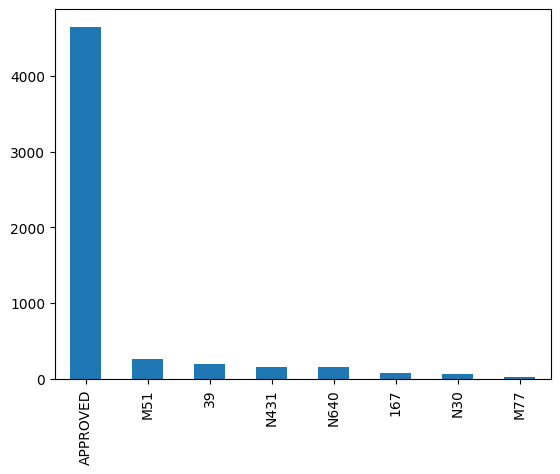

In [15]:
data['REASON_CODE'].value_counts().plot(kind='bar')

### Remove insignificant features
- Drop zero variance columns
- Drop Date Columns

In [16]:
col_removed_df = data.drop(columns_to_remove, axis=1)
col_removed_df.shape

(5600, 31)

In [17]:
col_removed_df.describe()

PLACE_OF_SERVICE_CODE  REVENUE_CENTER_CODE  SERVICE_UNIT_QUANTITY  \
count            5600.000000          5600.000000            5600.000000   
mean               32.125000           403.436250               5.000357   
std                27.489966           162.579557              22.058277   
min                11.000000            23.000000               0.000000   
25%                22.000000           300.000000               1.000000   
50%                23.000000           306.000000               1.000000   
75%                23.000000           450.000000               1.000000   
max                99.000000           987.000000             510.000000   

        PAID_AMOUNT  DISCHARGE_DISPOSITION_CODE  DUAL_STATUS  MEDICARE_STATUS  \
count   5600.000000                 5600.000000  5600.000000      5600.000000   
mean    2270.566986                    2.969107     4.060536        11.598214   
std     3797.149925                    7.558212     2.543021         4.452443   
min      -99.550000                    0.000000     0.000000         0.000000   
25%       90.220000                    1.000000     2.000000        10.000000   
50%      478.055000                    1.000000     4.000000        10.000000   
75%     2620.110000                    1.000000     6.000000        10.000000   
max    30269.540000                   70.000000     8.000000        20.000000   

       ADMIT_SOURCE_CODE  ADMIT_TYPE_CODE       MS_DRG  \
count        5600.000000      5600.000000  5600.000000   
mean            2.331607         1.923929   374.154643   
std             1.233949         0.840525   207.206144   
min             1.000000         1.000000    42.000000   
25%             1.000000         1.000000   247.000000   
50%             2.000000         2.000000   309.000000   
75%             4.000000         3.000000   442.000000   
max             4.000000         3.000000   920.000000   

       NO_OF_MEMBERS_IN_FAMILY  HIGH_COST_CLAIMANTS  
count              5600.000000          5600.000000  
mean                  4.474286             0.127143  
std                   1.641808             0.333163  
min                   2.000000             0.000000  
25%                   3.000000             0.000000  
50%                   4.000000             0.000000  
75%                   6.000000             0.000000  
max                   7.000000             1.000000

In [18]:
col_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BILL_TYPE_CODE              5600 non-null   object 
 1   PLACE_OF_SERVICE_CODE       5600 non-null   int64  
 2   REVENUE_CENTER_CODE         5600 non-null   int64  
 3   SERVICE_UNIT_QUANTITY       5600 non-null   int64  
 4   PAID_AMOUNT                 5600 non-null   float64
 5   HCPCS_CODE                  5600 non-null   object 
 6   DISCHARGE_DISPOSITION_CODE  5600 non-null   int64  
 7   GENDER                      5600 non-null   object 
 8   RACE                        5600 non-null   object 
 9   STATE                       5600 non-null   object 
 10  COUNTY                      5600 non-null   object 
 11  CODE                        5600 non-null   object 
 12  PRESENT_ON_ADMIT            5600 non-null   object 
 13  DUAL_STATUS                 5600 

### Devide into Categorical and Numerical columns

In [19]:
numerical_df = col_removed_df.select_dtypes(include='number')
categorical_df = col_removed_df.select_dtypes(include='object')

In [20]:
numerical_df.shape, categorical_df.shape

((5600, 12), (5600, 19))

In [21]:
cat_col_from_numerical_df = ['PLACE_OF_SERVICE_CODE' , 'REVENUE_CENTER_CODE', 'DISCHARGE_DISPOSITION_CODE','DUAL_STATUS', 'MEDICARE_STATUS','ADMIT_SOURCE_CODE','ADMIT_TYPE_CODE', 'MS_DRG', 'HIGH_COST_CLAIMANTS']
len(cat_col_from_numerical_df)

9

In [22]:
categorcal_cols = categorical_df.columns.tolist()
len(categorcal_cols)

19

In [23]:
categorcal_cols.extend(cat_col_from_numerical_df)
len(categorcal_cols)

28

In [24]:
categorical_df =  col_removed_df[categorcal_cols]
categorical_df.shape

(5600, 28)

In [25]:
numerical_cols = list(set(col_removed_df.columns).difference(set(categorical_df.columns)))
numerical_cols

['PAID_AMOUNT', 'NO_OF_MEMBERS_IN_FAMILY', 'SERVICE_UNIT_QUANTITY']

**NO_OF_MEMBERS_IN_FAMILY** will be investigated again.

In [26]:
numerical_df = col_removed_df[numerical_cols]
numerical_df.shape

(5600, 3)

In [27]:
set(numerical_df.columns).intersection(categorical_df.columns)

set()

In [28]:
numerical_df.shape, categorical_df.shape

((5600, 3), (5600, 28))

In [29]:
#Null Check
numerical_df.isna().sum()

PAID_AMOUNT                0
NO_OF_MEMBERS_IN_FAMILY    0
SERVICE_UNIT_QUANTITY      0
dtype: int64

In [30]:
#Null Check
categorical_df.isna().sum()

BILL_TYPE_CODE                0
HCPCS_CODE                    0
GENDER                        0
RACE                          0
STATE                         0
COUNTY                        0
CODE                          0
PRESENT_ON_ADMIT              0
ENCOUNTER_TYPE                0
EDUCATION                     0
MINORITY_STATUS               0
HOUSING                       0
POVERTY_LEVEL                 0
SOCIALLY_VULNERABLE           0
PRE_EXISTING_ILLNESS          0
CLAIM_STATUS                  0
PAYERS                        0
DENIAL_CATEGORY               0
REASON_CODE                   0
PLACE_OF_SERVICE_CODE         0
REVENUE_CENTER_CODE           0
DISCHARGE_DISPOSITION_CODE    0
DUAL_STATUS                   0
MEDICARE_STATUS               0
ADMIT_SOURCE_CODE             0
ADMIT_TYPE_CODE               0
MS_DRG                        0
HIGH_COST_CLAIMANTS           0
dtype: int64

In [31]:
data.CLAIM_STATUS.value_counts()

Approved    4653
Denied       947
Name: CLAIM_STATUS, dtype: int64

In [32]:
total_cat_cols = 0
for col in categorical_df.columns:
    #print(col)
    total_cat_cols += len(categorical_df.loc[:,col].value_counts())
print(f'total_cat_cols : {total_cat_cols}')

total_cat_cols : 2339


In [33]:
#HANDLE NUMERICAL DF
numerical_df.head()

PAID_AMOUNT  NO_OF_MEMBERS_IN_FAMILY  SERVICE_UNIT_QUANTITY
0       259.01                        7                      1
1       259.01                        7                      1
2       259.01                        7                      1
3       259.01                        7                      1
4       259.01                        7                      1

In [34]:
categorical_df.head()

BILL_TYPE_CODE HCPCS_CODE GENDER   RACE     STATE    COUNTY    CODE  \
0            131      G0283   male  white  New York  New York  M25551   
1            131      G0283   male  white  New York  New York  M79604   
2            131      G0283   male  white  New York  New York  Z01812   
3            131      G0283   male  white  New York  New York    D649   
4            131      G0283   male  white  New York  New York   M7989   

  PRESENT_ON_ADMIT ENCOUNTER_TYPE    EDUCATION  ... REASON_CODE  \
0                N     Outpatient  High School  ...    APPROVED   
1                N     Outpatient  High School  ...    APPROVED   
2                N     Outpatient  High School  ...    APPROVED   
3                N     Outpatient  High School  ...    APPROVED   
4                N     Outpatient  High School  ...    APPROVED   

  PLACE_OF_SERVICE_CODE REVENUE_CENTER_CODE DISCHARGE_DISPOSITION_CODE  \
0                    23                 420                          1   
1                    23                 420                          1   
2                    23                 420                          1   
3                    23                 420                          1   
4                    23                 420                          1   

  DUAL_STATUS MEDICARE_STATUS ADMIT_SOURCE_CODE ADMIT_TYPE_CODE MS_DRG  \
0           2              10                 1               1    470   
1           2              10                 1               1    470   
2           2              10                 1               1    470   
3           2              10                 1               1    470   
4           2              10                 1               1    470   

   HIGH_COST_CLAIMANTS  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 28 columns]

In [35]:
merged = pd.concat([numerical_df, categorical_df],axis=1 )
merged.shape

(5600, 31)

In [36]:
merged.head()

PAID_AMOUNT  NO_OF_MEMBERS_IN_FAMILY  SERVICE_UNIT_QUANTITY BILL_TYPE_CODE  \
0       259.01                        7                      1            131   
1       259.01                        7                      1            131   
2       259.01                        7                      1            131   
3       259.01                        7                      1            131   
4       259.01                        7                      1            131   

  HCPCS_CODE GENDER   RACE     STATE    COUNTY    CODE  ... REASON_CODE  \
0      G0283   male  white  New York  New York  M25551  ...    APPROVED   
1      G0283   male  white  New York  New York  M79604  ...    APPROVED   
2      G0283   male  white  New York  New York  Z01812  ...    APPROVED   
3      G0283   male  white  New York  New York    D649  ...    APPROVED   
4      G0283   male  white  New York  New York   M7989  ...    APPROVED   

  PLACE_OF_SERVICE_CODE REVENUE_CENTER_CODE DISCHARGE_DISPOSITION_CODE  \
0                    23                 420                          1   
1                    23                 420                          1   
2                    23                 420                          1   
3                    23                 420                          1   
4                    23                 420                          1   

  DUAL_STATUS MEDICARE_STATUS ADMIT_SOURCE_CODE ADMIT_TYPE_CODE MS_DRG  \
0           2              10                 1               1    470   
1           2              10                 1               1    470   
2           2              10                 1               1    470   
3           2              10                 1               1    470   
4           2              10                 1               1    470   

  HIGH_COST_CLAIMANTS  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 31 columns]

### Addressing duplicate rows

In [37]:
merged[merged.duplicated()].shape

(54, 31)

In [38]:
merged.shape

(5600, 31)

There are 51 duplicate rows. We'll be removing those.

In [39]:
merged_no_dup = merged.drop_duplicates()
merged_no_dup.shape

(5546, 31)

### Pandas Profiling to understand the features & their relationships

In [40]:
#profile = ProfileReport(merged_no_dup, title="CLAIMS DENIAL ANALYSIS",html={"style":{"full_width":True}})
#profile

In [41]:
#profile.to_file(output_file="output.html")

In [42]:
len(categorcal_cols)

28

In [43]:
categorcal_cols

['BILL_TYPE_CODE',
 'HCPCS_CODE',
 'GENDER',
 'RACE',
 'STATE',
 'COUNTY',
 'CODE',
 'PRESENT_ON_ADMIT',
 'ENCOUNTER_TYPE',
 'EDUCATION',
 'MINORITY_STATUS',
 'HOUSING',
 'POVERTY_LEVEL',
 'SOCIALLY_VULNERABLE',
 'PRE_EXISTING_ILLNESS',
 'CLAIM_STATUS',
 'PAYERS',
 'DENIAL_CATEGORY',
 'REASON_CODE',
 'PLACE_OF_SERVICE_CODE',
 'REVENUE_CENTER_CODE',
 'DISCHARGE_DISPOSITION_CODE',
 'DUAL_STATUS',
 'MEDICARE_STATUS',
 'ADMIT_SOURCE_CODE',
 'ADMIT_TYPE_CODE',
 'MS_DRG',
 'HIGH_COST_CLAIMANTS']

In [44]:
pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True).shape

(5546, 2314)

**HCPCS_CODE** has a high cardinality: 604 distinct values	High cardinality

**COUNTY** has a high cardinality: 306 distinct values	High cardinality

**CODE** has a high cardinality: 1118 distinct values

<AxesSubplot: >

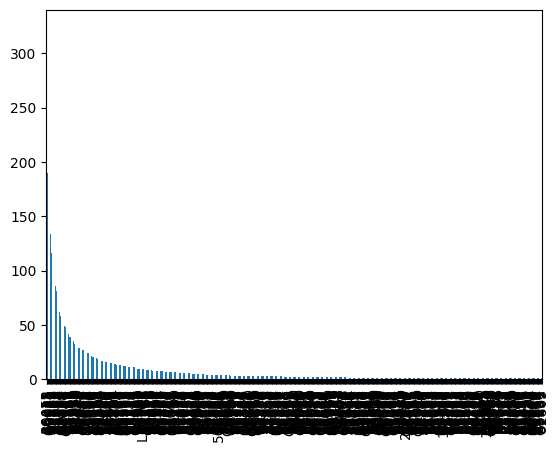

In [45]:
merged_no_dup['HCPCS_CODE'].value_counts().plot(kind='bar')

<AxesSubplot: >

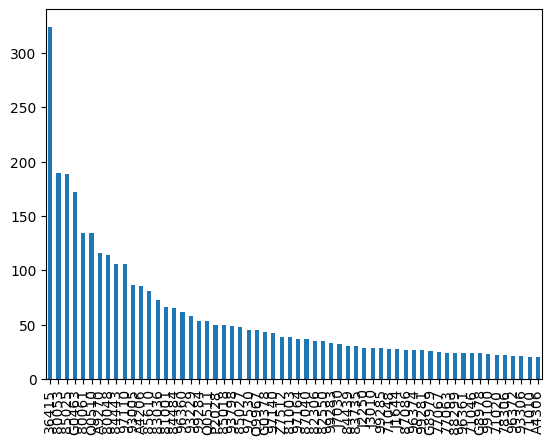

In [46]:
merged_no_dup['HCPCS_CODE'].value_counts()[:60].plot(kind='bar')

In [47]:
merged_no_dup['HCPCS_CODE'].value_counts()[:61].index

Index(['36415', '80053', '85025', 'G0463', '80061', 'Q0510', 'A9270', '80048',
       '84443', '97110', '93005', 'A4206', '85610', '83036', '81001', '84484',
       '96360', '93229', '99284', 'Q0511', 'P2028', '85018', '93798', '85027',
       '97530', 'Q9967', 'G0378', '97140', 'Z7512', '81003', '97164', '87040',
       '82306', '82550', '99283', 'J7030', '84439', '83735', 'J2250', 'J3010',
       '99285', '71048', 'J1644', '87086', '96374', '99281', 'G8979', '77067',
       '77063', '88299', '96361', '71046', 'G8978', '99100', '71020', '78306',
       '96372', '93306', '71010', 'A4306', '85730'],
      dtype='object')

In [48]:
merged_no_dup['COUNTY'].value_counts()

Fairfield     125
Bailey        108
La Porte      107
Cumberland    101
Suffolk        90
             ... 
Bucks           1
Cambria         1
Gwinnett        1
Swain           1
El Paso         1
Name: COUNTY, Length: 306, dtype: int64

In [49]:
merged_no_dup['CODE'].value_counts()

I10        310
E785       174
I2510      173
R079        79
E039        76
          ... 
S43432A      1
M75112       1
Z9109        1
Z8701        1
S92901A      1
Name: CODE, Length: 1118, dtype: int64

In [50]:
def fix_cardinality(merged_no_dup, column, new_value ,in_freq = 30, ):
    # count frequencies of each value in the column
    value_counts = merged_no_dup[column].value_counts()

    # create dictionary mapping values to their frequencies
    freq_dict = dict(value_counts)

    # assign a unique value to all values with frequency less than 30
    for value, freq in freq_dict.items():
        if freq < in_freq:
            merged_no_dup.loc[merged_no_dup[column] == value, column] = new_value 
    return merged_no_dup

In [51]:
merged_no_dup = fix_cardinality(merged_no_dup,column='HCPCS_CODE', in_freq=30, new_value='85730')
merged_no_dup.shape

(5546, 31)

In [52]:
merged_no_dup = fix_cardinality(merged_no_dup,column='COUNTY', in_freq=50, new_value='COUNTY_X')
merged_no_dup.shape

(5546, 31)

In [53]:
merged_no_dup = fix_cardinality(merged_no_dup,column='CODE', in_freq=173, new_value="CODE_X")
merged_no_dup.shape

(5546, 31)

In [54]:
categorcal_cols_original = categorcal_cols

In [55]:
categorcal_cols = [col for col in categorcal_cols if col != 'REASON_CODE']
len(categorcal_cols)

27

In [56]:
dumy_encoded = pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True)
dumy_encoded.shape

(5546, 352)

In [57]:
dumy_encoded.head()

PAID_AMOUNT  NO_OF_MEMBERS_IN_FAMILY  SERVICE_UNIT_QUANTITY REASON_CODE  \
0       259.01                        7                      1    APPROVED   
1       259.01                        7                      1    APPROVED   
2       259.01                        7                      1    APPROVED   
3       259.01                        7                      1    APPROVED   
4       259.01                        7                      1    APPROVED   

   BILL_TYPE_CODE_111  BILL_TYPE_CODE_112  BILL_TYPE_CODE_117  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   BILL_TYPE_CODE_11I  BILL_TYPE_CODE_124  BILL_TYPE_CODE_130  ...  \
0                   0                   0                   0  ...   
1                   0                   0                   0  ...   
2                   0                   0                   0  ...   
3                   0                   0                   0  ...   
4                   0                   0                   0  ...   

   MS_DRG_470  MS_DRG_481  MS_DRG_603  MS_DRG_641  MS_DRG_683  MS_DRG_690  \
0           1           0           0           0           0           0   
1           1           0           0           0           0           0   
2           1           0           0           0           0           0   
3           1           0           0           0           0           0   
4           1           0           0           0           0           0   

   MS_DRG_871  MS_DRG_872  MS_DRG_920  HIGH_COST_CLAIMANTS_1  
0           0           0           0                      0  
1           0           0           0                      0  
2           0           0           0                      0  
3           0           0           0                      0  
4           0           0           0                      0  

[5 rows x 352 columns]

In [58]:
dumy_encoded.describe()


PAID_AMOUNT  NO_OF_MEMBERS_IN_FAMILY  SERVICE_UNIT_QUANTITY  \
count   5546.000000              5546.000000            5546.000000   
mean    2235.997836                 4.476740               4.989362   
std     3773.189472                 1.643826              22.126778   
min      -99.550000                 2.000000               0.000000   
25%       89.580000                 3.000000               1.000000   
50%      467.230000                 4.000000               1.000000   
75%     2130.400000                 6.000000               1.000000   
max    30269.540000                 7.000000             510.000000   

       BILL_TYPE_CODE_111  BILL_TYPE_CODE_112  BILL_TYPE_CODE_117  \
count         5546.000000         5546.000000         5546.000000   
mean             0.128020            0.000180            0.007573   
std              0.334142            0.013428            0.086701   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       BILL_TYPE_CODE_11I  BILL_TYPE_CODE_124  BILL_TYPE_CODE_130  \
count         5546.000000         5546.000000         5546.000000   
mean             0.005590            0.001082            0.002344   
std              0.074561            0.032877            0.048363   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       BILL_TYPE_CODE_131  ...   MS_DRG_470   MS_DRG_481   MS_DRG_603  \
count          5546.00000  ...  5546.000000  5546.000000  5546.000000   
mean              0.59863  ...     0.028850     0.019293     0.013523   
std               0.49022  ...     0.167399     0.137566     0.115511   
min               0.00000  ...     0.000000     0.000000     0.000000   
25%               0.00000  ...     0.000000     0.000000     0.000000   
50%               1.00000  ...     0.000000     0.000000     0.000000   
75%               1.00000  ...     0.000000     0.000000     0.000000   
max               1.00000  ...     1.000000     1.000000     1.000000   

        MS_DRG_641   MS_DRG_683   MS_DRG_690   MS_DRG_871   MS_DRG_872  \
count  5546.000000  5546.000000  5546.000000  5546.000000  5546.000000   
mean      0.027227     0.035160     0.012622     0.025965     0.029391   
std       0.162758     0.184202     0.111645     0.159044     0.168914   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        MS_DRG_920  HIGH_COST_CLAIMANTS_1  
count  5546.000000            5546.000000  
mean      0.022358               0.122431  
std       0.147860               0.327812  
min       0.000000               0.000000  
25%       0.000000               0.000000  
50%       0.000000               0.000000  
75%       0.000000               0.000000  
max       1.000000               1.000000  

[8 rows x 351 columns]

### Features to be Normalized/Standardized

In [59]:
norm_features = []
desc = dumy_encoded.describe()
for col in desc.columns:
    if desc.loc[:,col]['std'] > 3:
        norm_features.append(col)
        #print(col)
print(f' Features to be Normalized are : {norm_features}')

 Features to be Normalized are : ['PAID_AMOUNT', 'SERVICE_UNIT_QUANTITY']


Create X, y 

In [60]:
X = dumy_encoded.drop(columns='REASON_CODE')
y = dumy_encoded['REASON_CODE']
print(f'X:{X.shape} \n y:{y.shape}')

X:(5546, 351) 
 y:(5546,)


### Data Split

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8675309)

In [62]:
print(f'X_train : {X_train.shape}\n X_test:{X_test.shape}\n y_train:{y_train.shape}\n y_test:{y_test.shape}')

X_train : (4159, 351)
 X_test:(1387, 351)
 y_train:(4159,)
 y_test:(1387,)


In [63]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

### Feature Normalization

In [64]:
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])


MinMaxScaler()

In [65]:
scaled = scaler.transform(X_train[norm_features])
X_train['PAID_AMOUNT'] =  scaled[:,0]
X_train['SERVICE_UNIT_QUANTITY'] =  scaled[:,1]
X_train.shape

(4159, 351)

In [66]:
X_train[norm_features]

PAID_AMOUNT  SERVICE_UNIT_QUANTITY
1206     0.033329               0.001961
2254     0.319977               0.001961
4912     0.004152               0.001961
2373     0.021241               0.001961
1033     0.007626               0.001961
...           ...                    ...
531      0.003278               0.001961
5404     0.310763               0.029412
5427     0.006025               0.001961
2711     0.006316               0.001961
4658     0.006534               0.001961

[4159 rows x 2 columns]

## Modeling

#### Logistic Regression

In [67]:
#LOGISTIC REGRESSION

lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [78]:
scaled = scaler.transform(X_test[norm_features])
X_test['PAID_AMOUNT'] =  scaled[:,0]
X_test['SERVICE_UNIT_QUANTITY'] =  scaled[:,1]
X_test.shape

(1387, 351)

In [79]:
preds = lr_model.predict(X_test)
train_preds = lr_model.predict(X_train)

In [80]:
print(f'LogisticRegression Test Accuracy: {accuracy_score(y_test, preds) * 100:.2f}')
print(f'LogisticRegression Train Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}')

LogisticRegression Test Accuracy: 86.73
LogisticRegression Train Accuracy: 93.89


In [81]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [82]:
pred_test= dt_model.predict(X_test)
pred_train= dt_model.predict(X_train)

In [83]:
print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

DecisionTreeClassifier Test Accuracy: 86.59
DecisionTreeClassifier Train Accuracy: 100.00


In [74]:
#Visualizing a Decision Tree
#from sklearn.tree import plot_tree, export_text
#plt.figure(figsize =(80,20))

#plot_tree(dt_model, feature_names=X_train.columns, max_depth=5, filled=True)

<Figure size 8000x2000 with 0 Axes>

<Figure size 8000x2000 with 0 Axes>

In [84]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=24)

In [85]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [86]:
print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

DecisionTreeClassifier Test Accuracy: 86.95
DecisionTreeClassifier Train Accuracy: 100.00


In [88]:
y_hat_train = lr_model.predict(X_train)
y_hat_test = lr_model.predict(X_test)
print(f'{lr_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{lr_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

LogisticRegression(max_iter=1000, multi_class='multinomial') Test Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.17      0.20      0.18        44
           2       1.00      1.00      1.00      1167
           3       0.19      0.25      0.22        56
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        21
           6       0.13      0.20      0.16        30
           7       0.24      0.18      0.21        38

    accuracy                           0.87      1387
   macro avg       0.22      0.23      0.22      1387
weighted avg       0.86      0.87      0.87      1387

LogisticRegression(max_iter=1000, multi_class='multinomial') Train Accuracy Classification report:               precision    recall  f1-score   support

           0       0.66      0.42      0.51        55
           1       0.62      0.70      0.65       15

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [90]:
y_hat_train = dt_model.predict(X_train)
y_hat_test = dt_model.predict(X_test)
print(f'{dt_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{dt_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

DecisionTreeClassifier(random_state=42) Test Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.23      0.30      0.26        44
           2       1.00      1.00      1.00      1167
           3       0.19      0.21      0.20        56
           4       0.20      0.10      0.13        10
           5       0.00      0.00      0.00        21
           6       0.17      0.23      0.19        30
           7       0.04      0.03      0.03        38

    accuracy                           0.87      1387
   macro avg       0.23      0.23      0.23      1387
weighted avg       0.86      0.87      0.86      1387

DecisionTreeClassifier(random_state=42) Train Accuracy Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00       155
           2       1.00      1.00      1

In [91]:
y_hat_train = rf_model.predict(X_train)
y_hat_test = dt_model.predict(X_test)
print(f'{rf_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{rf_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

RandomForestClassifier(n_jobs=-1, random_state=24) Test Classification report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.23      0.30      0.26        44
           2       1.00      1.00      1.00      1167
           3       0.19      0.21      0.20        56
           4       0.20      0.10      0.13        10
           5       0.00      0.00      0.00        21
           6       0.17      0.23      0.19        30
           7       0.04      0.03      0.03        38

    accuracy                           0.87      1387
   macro avg       0.23      0.23      0.23      1387
weighted avg       0.86      0.87      0.86      1387

RandomForestClassifier(n_jobs=-1, random_state=24) Train Accuracy Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00       155
           2      

In [ ]:
#1. Anomaly Detection
#2. Imbalance
#3. Improve the classification models.